## DPC main

## 01. Prepare packages

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
import pandas as pd
from typing import Optional, Tuple

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import pickle
from pickle import dump
from sklearn.preprocessing import MinMaxScaler
import time
from torch.nn import ReLU

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")

from sklearn.preprocessing import StandardScaler
import torch.autograd.functional as F


from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

cuda is available


## 02. Load Policy & Tide

In [7]:
window = 10
P = 10

def load_fcnn_model(setting_name, model_class, device="cpu"):
    import re
    # setting_name 예: '5L_512H'
    match = re.match(r"(\d+)L_(\d+)H", setting_name)
    if match is None:
        raise ValueError(f"Invalid setting name format: {setting_name}")
    n_layers = int(match.group(1))
    hidden_dim = int(match.group(2))

    model = model_class(
        input_dim=6,
        output_dim=1,
        future_cov_dim=2,
        static_cov_dim=0, 
        input_chunk_length=window,
        output_chunk_length=P,
        hidden_dim=hidden_dim,
        n_layers=n_layers
    ).to(device)

    model.load_state_dict(torch.load(f"policy_model_{setting_name}.pth", map_location=device))
    model.eval()
    return model

from DPC_Policy_dynamic import DPC_PolicyNN

setting_name = "5L_512H"
NNPolicy_basic = load_fcnn_model(setting_name, DPC_PolicyNN, device="cpu")


In [8]:
with open('nominal_params_w10_mid_noise_stable_final.pkl', 'rb') as file: 
    nominal_params = pickle.load(file)
nominal_TiDE = nominal_params['model'].to("cpu")
nominal_TiDE.load_state_dict(torch.load('nominal_params_w10_mid_noise_stable_final.pth'))
nominal_TiDE.eval()
nominal_TiDE = nominal_TiDE.to(device)

## 03. Define Iteration

In [9]:
def NNPolicy_iteration(ref_future:torch.tensor, 
                x_past:torch.tensor, 
                u_past:torch.tensor, 
                c_fut:torch.tensor,
                NN_Nominal, 
):
    x_fut_in = ref_future
    past_cov = torch.cat([x_past.to(torch.float32), u_past.to(torch.float32)], dim=2)
    x_fut_in = x_fut_in.to(torch.float32)
    c_fut_in = c_fut.to(torch.float32)

    u_future_policy = NN_Nominal([past_cov,x_fut_in,c_fut_in,None]).squeeze(-1) 
    u_future_decision_policy = u_future_policy[:, 1, :].squeeze()

    return u_future_policy, u_future_decision_policy

## 04. Run Iteration

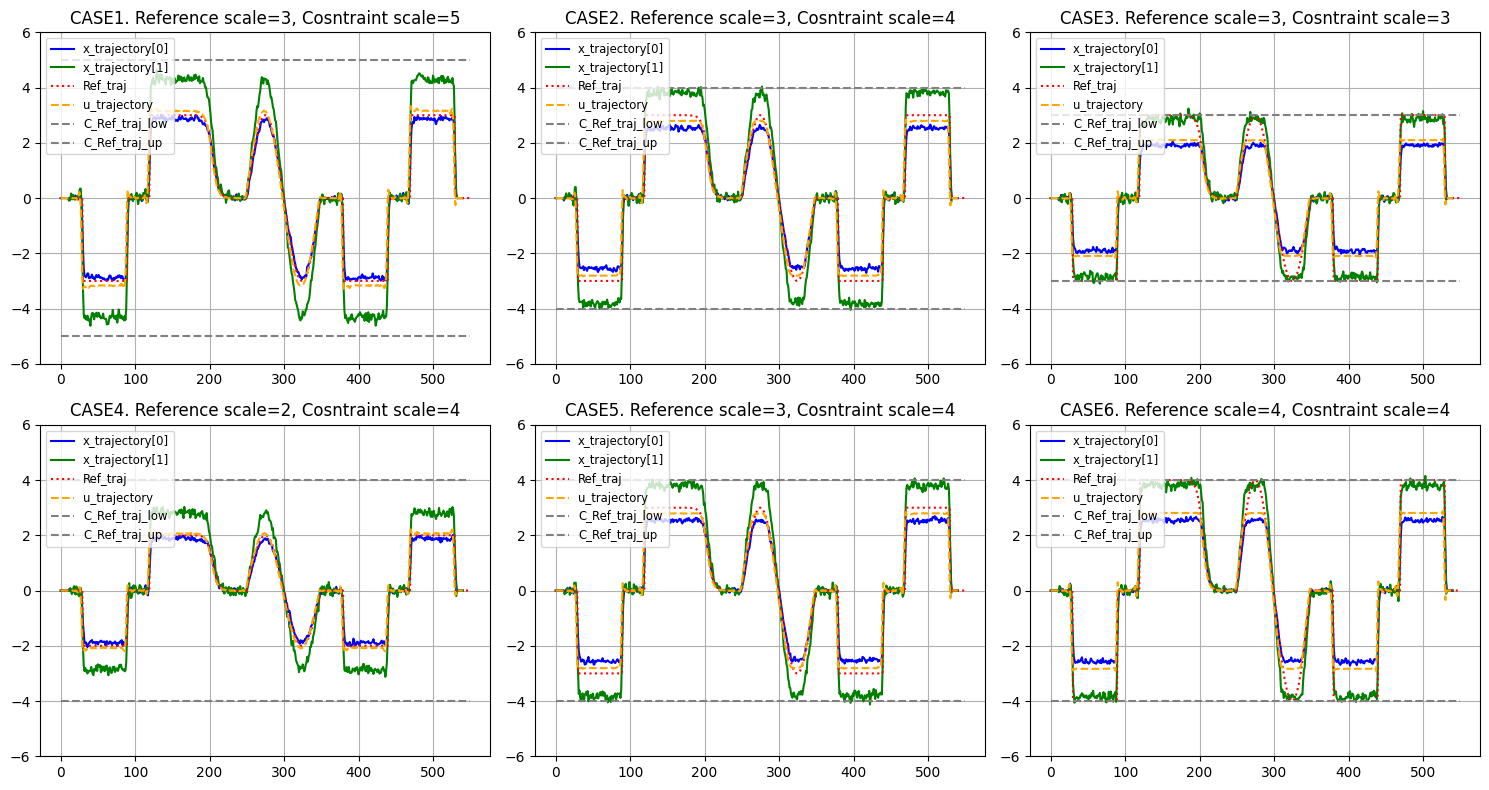

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def f_ss(x0, u):
    A = np.array([[0.3, 0.1], [0.1, 0.2]]) 
    # A = np.array([[0.3, 0.1], [0.1, 0.2]])
    B = np.array([[0.5], [1.0]])
    # B = np.array([[0.5], [1.0]])
    mu = np.array([[0], [0]]) * 0
    w = np.array([[0.05], [0.1]])
    x = A @ x0 + B * u + np.random.normal(mu, w, size=(2, 1))
    return x

def run_simulation(scale, c_scale):
    Ref_traj_step = torch.tensor(np.repeat(np.array([0, -scale, -scale, 0, scale, scale]), 30))

    def sigmoid(x):
        return 1 / (1 + np.exp(-x / 4))

    x = np.linspace(0, 50, 50)
    y = -sigmoid(x - 25) * scale + scale
    Ref_traj_sigmoid = torch.tensor(y)

    x_sin = np.linspace(0, 2 * np.pi, 100)
    y_sin = scale * np.sin(x_sin)
    Ref_traj_sin = torch.tensor(y_sin)

    Ref_traj = torch.cat((Ref_traj_step, Ref_traj_sigmoid, torch.zeros(20), Ref_traj_sin, Ref_traj_step, torch.zeros(20)))
    tot_step = len(Ref_traj)

    C_Ref_traj_low = torch.tensor(np.repeat(np.array([-c_scale]), tot_step))
    C_Ref_traj_up = torch.tensor(np.repeat(np.array([c_scale]), tot_step))

    x1_diff = 9.32425809
    x2_diff = 14.13760952
    u_diff = 9.992800291743697
    window = 10

    Ref_traj = Ref_traj / (x1_diff / 2)
    C_Ref_traj_low = C_Ref_traj_low / (x2_diff / 2)
    C_Ref_traj_up = C_Ref_traj_up / (x2_diff / 2)

    sliding_data_ref_x1 = Ref_traj.unfold(0, window, 1)
    sliding_data_con_x2_low = C_Ref_traj_low.unfold(0, window, 1)
    sliding_data_con_x2_up = C_Ref_traj_up.unfold(0, window, 1)
    sliding_data_con_x2 = torch.stack((sliding_data_con_x2_low, sliding_data_con_x2_up), dim=-1)

    num_steps = len(Ref_traj) - window + 1

    x_trajectory = torch.zeros(num_steps, 2, dtype=torch.float32)
    u_trajectory = torch.zeros(num_steps, 1, dtype=torch.float32)

    for i in range(num_steps - 20):
        x_past_policy = x_trajectory[i:i + window, :].unsqueeze(0)
        u_past_policy = u_trajectory[i:i + window, :].unsqueeze(0)
        x_ref_policy = torch.tensor(sliding_data_ref_x1[i + window]).unsqueeze(0)
        c_fut_policy = torch.tensor(sliding_data_con_x2[i + window]).unsqueeze(0)

        u_future_policy, u_future_decision_policy = NNPolicy_iteration(
            x_ref_policy, x_past_policy, u_past_policy, c_fut_policy, NNPolicy_basic
        )

        u_trajectory[i + window] = u_future_decision_policy.squeeze()

        x_f = x_trajectory[i + window, :].unsqueeze(-1)
        u_f = u_future_decision_policy.unsqueeze(0).unsqueeze(0)

        x_f_denorm = x_f.clone()
        u_f_denorm = u_f.clone()
        x_f_denorm[0] = x_f_denorm[0] * (x1_diff / 2)
        x_f_denorm[1] = x_f_denorm[1] * (x2_diff / 2)
        u_f_denorm[0] = u_f_denorm[0] * (u_diff / 2)

        x_f_np = x_f_denorm.detach().cpu().numpy()
        u_f_np = u_f_denorm.detach().cpu().numpy()
        x_next = torch.tensor(f_ss(x_f_np, u_f_np), dtype=torch.float32).squeeze(-1)

        x_next[0] = x_next[0] / (x1_diff / 2)
        x_next[1] = x_next[1] / (x2_diff / 2)

        x_trajectory[i + window + 1, :] = x_next

    x_trajectory[:, 0] *= x1_diff / 2
    x_trajectory[:, 1] *= x2_diff / 2
    u_trajectory[:, 0] *= u_diff / 2
    Ref_traj *= x1_diff / 2
    C_Ref_traj_low *= x2_diff / 2
    C_Ref_traj_up *= x2_diff / 2

    return x_trajectory, u_trajectory, Ref_traj, C_Ref_traj_low, C_Ref_traj_up

test_cases = [
    (3, 5), (3, 4), (3, 3),  
    (2, 4), (3, 4), (4, 4) 
]

titles = [
    "CASE1. Reference scale=3, Cosntraint scale=5", "CASE2. Reference scale=3, Cosntraint scale=4", "CASE3. Reference scale=3, Cosntraint scale=3",
    "CASE4. Reference scale=2, Cosntraint scale=4", "CASE5. Reference scale=3, Cosntraint scale=4", "CASE6. Reference scale=4, Cosntraint scale=4"
]

results = [run_simulation(scale, c_scale) for scale, c_scale in test_cases]
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, (x_trajectory, u_trajectory, Ref_traj, C_Ref_traj_low, C_Ref_traj_up) in enumerate(results):
    ax = axes[i]
    ax.plot(x_trajectory[:, 0].detach().cpu().numpy(), label="x_trajectory[0]", color="b")
    ax.plot(x_trajectory[:, 1].detach().cpu().numpy(), label="x_trajectory[1]", color="g")
    ax.plot(Ref_traj.detach().cpu().numpy(), label="Ref_traj", color="r", linestyle="dotted")
    ax.plot(u_trajectory[:, 0].detach().cpu().numpy(), label="u_trajectory", color="orange", linestyle="dashed")
    ax.plot(C_Ref_traj_low.detach().cpu().numpy(), label="C_Ref_traj_low", color="gray", linestyle="dashed")
    ax.plot(C_Ref_traj_up.detach().cpu().numpy(), label="C_Ref_traj_up", color="gray", linestyle="dashed")
    ax.set_title(titles[i])
    ax.legend(loc="upper left", fontsize="small")
    ax.grid()
    ax.set_ylim(-6, 6)

plt.tight_layout()
plt.show()


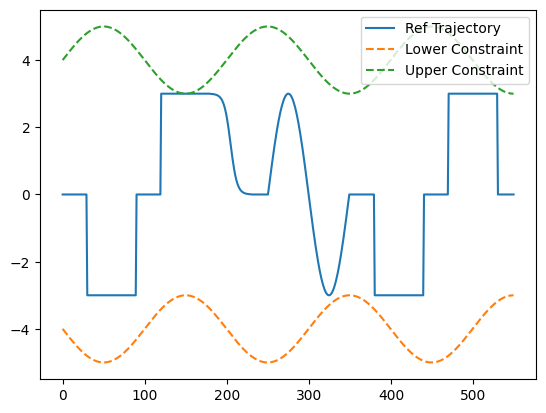

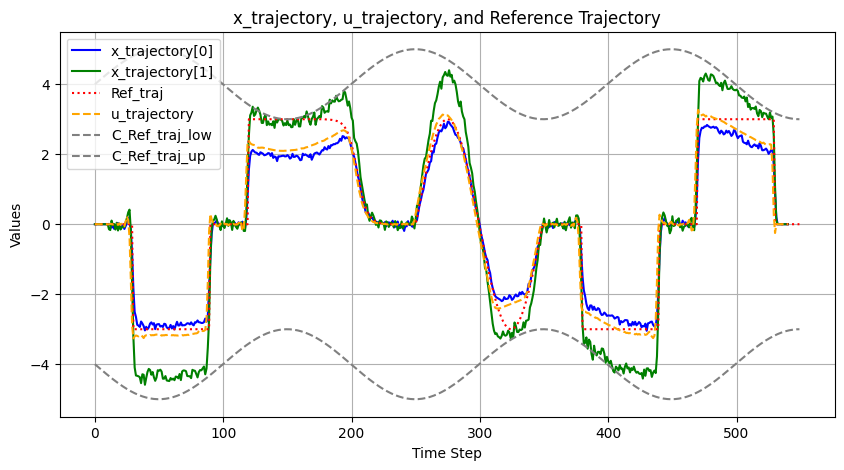

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt

scaling = 3
Ref_traj_step = torch.tensor(np.repeat(np.array([0, -scaling, -scaling, 0, scaling, scaling]), 30))
def sigmoid(x):
    return 1 / (1 + np.exp(-x / 4))

a = scaling
x = np.linspace(0, 50, 50)
y = -sigmoid(x - 25) * a + scaling
Ref_traj_sigmoid = torch.tensor(y)

x_sin = np.linspace(0, 2 * np.pi, 100)  
y_sin = scaling * np.sin(x_sin) 
Ref_traj_sin = torch.tensor(y_sin)

Ref_traj = torch.cat((Ref_traj_step, Ref_traj_sigmoid, torch.zeros(20), Ref_traj_sin, Ref_traj_step, torch.zeros(20)))
tot_step = len(Ref_traj)

x_constraint = np.linspace(0, tot_step, tot_step)
C_Ref_traj_up = torch.tensor(4 + 1 * np.sin(2 * np.pi * x_constraint / 200))
C_Ref_traj_low = -C_Ref_traj_up  


plt.plot(Ref_traj.numpy(), label="Ref Trajectory", linestyle='-')
plt.plot(C_Ref_traj_low.numpy(), label="Lower Constraint", linestyle='--')
plt.plot(C_Ref_traj_up.numpy(), label="Upper Constraint", linestyle='--')

plt.legend(loc = "upper right")
plt.show()

window = 10
p = 10
tot_window = len(Ref_traj)

x1_diff = 9.32425809 
x2_diff = 14.13760952
u_diff = 9.992800291743697 
Ref_traj = Ref_traj/ (x1_diff/2)
C_Ref_traj_low = C_Ref_traj_low / (x2_diff/2)
C_Ref_traj_up = C_Ref_traj_up / (x2_diff/2)

sliding_data_ref_x1 = Ref_traj.unfold(0, window, 1)
sliding_data_con_x2_low = C_Ref_traj_low.unfold(0, window, 1)
sliding_data_con_x2_up = C_Ref_traj_up.unfold(0, window, 1)
sliding_data_con_x2 = torch.stack((sliding_data_con_x2_low, sliding_data_con_x2_up), dim=-1)

num_steps = len(Ref_traj)-window+1

import torch

x_trajectory = torch.zeros(num_steps, 2, dtype=torch.float32)
u_trajectory = torch.zeros(num_steps, 1, dtype=torch.float32)

for i in range(num_steps - 20):

    x_past_policy = x_trajectory[i:i+window, :].unsqueeze(0)  
    u_past_policy = u_trajectory[i:i+window, :].unsqueeze(0) 

    x_ref_policy = torch.tensor(sliding_data_ref_x1[i+window]).unsqueeze(0)

    c_fut_policy = torch.tensor(sliding_data_con_x2[i+window]).unsqueeze(0)  
    u_future_policy, u_future_decision_policy = NNPolicy_iteration(
        x_ref_policy, x_past_policy, u_past_policy, c_fut_policy, NNPolicy_basic
    )

    u_trajectory[i+window] = u_future_decision_policy.squeeze()
    x_f = x_trajectory[i+window, :].unsqueeze(-1)
    u_f = u_future_decision_policy.unsqueeze(0).unsqueeze(0)

    x_f_denorm = x_f.clone() 
    u_f_denorm = u_f.clone() 

    x_f_denorm[0] = x_f_denorm[0] * (x1_diff / 2)
    x_f_denorm[1] = x_f_denorm[1] * (x2_diff / 2)
    u_f_denorm[0] = u_f_denorm[0] * (u_diff / 2)

    x_f_np = x_f_denorm.detach().cpu().numpy() 
    u_f_np = u_f_denorm.detach().cpu().numpy()  
    x_next = torch.tensor(f_ss(x_f_np, u_f_np), dtype=torch.float32).squeeze(-1)

    x_next[0] = x_next[0] / (x1_diff / 2)
    x_next[1] = x_next[1] / (x2_diff / 2)
    x_trajectory[i+window+1, :] = x_next  


x_trajectory[:, 0] = x_trajectory[:, 0] * (x1_diff / 2)  
x_trajectory[:, 1] = x_trajectory[:, 1] * (x2_diff / 2)  
u_trajectory[:, 0] = u_trajectory[:, 0] * (u_diff / 2)  
Ref_traj = Ref_traj * (x1_diff / 2) 
C_Ref_traj_low = C_Ref_traj_low * (x2_diff / 2) 
C_Ref_traj_up = C_Ref_traj_up * (x2_diff / 2)  

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(x_trajectory[:, 0].detach().cpu().numpy(), label="x_trajectory[0]", color="b")
plt.plot(x_trajectory[:, 1].detach().cpu().numpy(), label="x_trajectory[1]", color="g")

plt.plot(Ref_traj.detach().cpu().numpy(), label="Ref_traj", color="r", linestyle="dotted")
plt.plot(u_trajectory[:, 0].detach().cpu().numpy(), label="u_trajectory", color="orange", linestyle="dashed")
plt.plot(C_Ref_traj_low.detach().cpu().numpy(), label="C_Ref_traj_low", color="gray", linestyle="dashed")
plt.plot(C_Ref_traj_up.detach().cpu().numpy(), label="C_Ref_traj_up", color="gray", linestyle="dashed")

plt.xlabel("Time Step")
plt.ylabel("Values")
plt.legend(loc="best")
plt.grid()
plt.title("x_trajectory, u_trajectory, and Reference Trajectory")
plt.show()



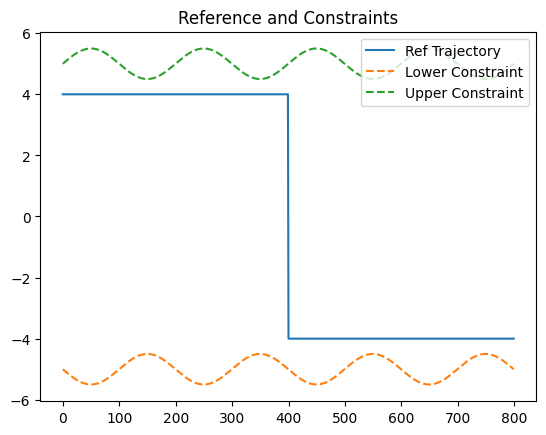

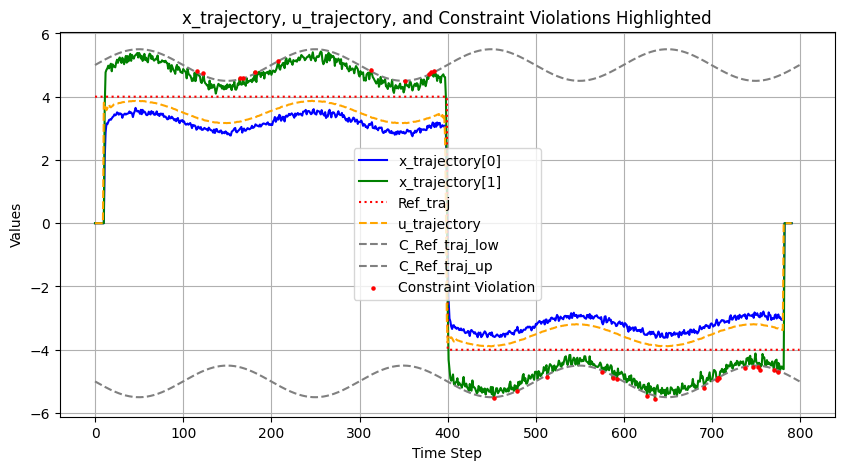

🔍 Total decision steps: 791
❌ Constraint violation steps: 30
📉 Violation rate: 3.79%

📏 Loss measured from step 100 to 700
📌 Tracking Loss      : 0.8408
📌 Smoothness Loss    : 0.0174
📌 Constraint Loss    : 0.0317
✅ Total Loss         : 0.8898

📏 Constraint RMSE (x2 vs nearest boundary) from step 100 to 700
📌 Constraint Distance RMSE : 0.2769


In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# ───────────────────────────────
# 1. Reference Trajectory 설정
# ───────────────────────────────
scaling = 4
total_steps = 800

# Step trajectory: 앞 400은 +4, 뒤 400은 -4
Ref_traj = torch.ones(total_steps) * (-scaling)
Ref_traj[:400] = scaling

# Constraint (sin) 한 주기 길이 = 200
x_constraint = np.linspace(0, total_steps, total_steps)
C_Ref_traj_up = torch.tensor(5 + 0.5 * np.sin(2 * np.pi * x_constraint / 200))
C_Ref_traj_low = -C_Ref_traj_up

# Plot
plt.plot(Ref_traj.numpy(), label="Ref Trajectory", linestyle='-')
plt.plot(C_Ref_traj_low.numpy(), label="Lower Constraint", linestyle='--')
plt.plot(C_Ref_traj_up.numpy(), label="Upper Constraint", linestyle='--')
plt.legend(loc="upper right")
plt.title("Reference and Constraints")
plt.show()

# ───────────────────────────────
# 2. Normalization & Sliding
# ───────────────────────────────
window = 10
p = 10

x1_diff = 9.32425809
x2_diff = 14.13760952
u_diff = 9.992800291743697

Ref_traj = Ref_traj / (x1_diff / 2)
C_Ref_traj_low = C_Ref_traj_low / (x2_diff / 2)
C_Ref_traj_up = C_Ref_traj_up / (x2_diff / 2)

sliding_data_ref_x1 = Ref_traj.unfold(0, window, 1)
sliding_data_con_x2_low = C_Ref_traj_low.unfold(0, window, 1)
sliding_data_con_x2_up = C_Ref_traj_up.unfold(0, window, 1)
sliding_data_con_x2 = torch.stack((sliding_data_con_x2_low, sliding_data_con_x2_up), dim=-1)

num_steps = len(Ref_traj) - window + 1

# ───────────────────────────────
# 3. 시뮬레이션
# ───────────────────────────────
x_trajectory = torch.zeros(num_steps, 2, dtype=torch.float32)
u_trajectory = torch.zeros(num_steps, 1, dtype=torch.float32)

for i in range(num_steps - 20):
    x_past_policy = x_trajectory[i:i+window, :].unsqueeze(0)
    u_past_policy = u_trajectory[i:i+window, :].unsqueeze(0)
    x_ref_policy = torch.tensor(sliding_data_ref_x1[i+window]).unsqueeze(0)
    c_fut_policy = torch.tensor(sliding_data_con_x2[i+window]).unsqueeze(0)

    u_future_policy, u_future_decision_policy = NNPolicy_iteration(
        x_ref_policy, x_past_policy, u_past_policy, c_fut_policy, NNPolicy_basic
    )

    u_trajectory[i+window] = u_future_decision_policy.squeeze()
    x_f = x_trajectory[i+window, :].unsqueeze(-1)
    u_f = u_future_decision_policy.unsqueeze(0).unsqueeze(0)

    x_f_denorm = x_f.clone()
    u_f_denorm = u_f.clone()
    x_f_denorm[0] = x_f_denorm[0] * (x1_diff / 2)
    x_f_denorm[1] = x_f_denorm[1] * (x2_diff / 2)
    u_f_denorm[0] = u_f_denorm[0] * (u_diff / 2)

    x_f_np = x_f_denorm.detach().cpu().numpy()
    u_f_np = u_f_denorm.detach().cpu().numpy()
    x_next = torch.tensor(f_ss(x_f_np, u_f_np), dtype=torch.float32).squeeze(-1)

    x_next[0] = x_next[0] / (x1_diff / 2)
    x_next[1] = x_next[1] / (x2_diff / 2)
    x_trajectory[i+window+1, :] = x_next

# ───────────────────────────────
# 4. 역정규화 & 시각화
# ───────────────────────────────
x_trajectory[:, 0] = x_trajectory[:, 0] * (x1_diff / 2)
x_trajectory[:, 1] = x_trajectory[:, 1] * (x2_diff / 2)
u_trajectory[:, 0] = u_trajectory[:, 0] * (u_diff / 2)
Ref_traj = Ref_traj * (x1_diff / 2)
C_Ref_traj_low = C_Ref_traj_low * (x2_diff / 2)
C_Ref_traj_up = C_Ref_traj_up * (x2_diff / 2)

# 1. Constraint 범위
x2 = x_trajectory[:, 1]
low = C_Ref_traj_low[:x2.shape[0]]
up = C_Ref_traj_up[:x2.shape[0]]


# 2. Violation mask
violation_mask = (x2 < low) | (x2 > up)
violation_indices = violation_mask.nonzero(as_tuple=True)[0]

# 3. 기존 선 그래프
plt.figure(figsize=(10, 5))
plt.plot(x_trajectory[:, 0].detach().cpu().numpy(), label="x_trajectory[0]", color="b")
plt.plot(x2.detach().cpu().numpy(), label="x_trajectory[1]", color="g")
plt.plot(Ref_traj.detach().cpu().numpy(), label="Ref_traj", color="r", linestyle="dotted")
plt.plot(u_trajectory[:, 0].detach().cpu().numpy(), label="u_trajectory", color="orange", linestyle="dashed")
plt.plot(C_Ref_traj_low.detach().cpu().numpy(), label="C_Ref_traj_low", color="gray", linestyle="dashed")
plt.plot(C_Ref_traj_up.detach().cpu().numpy(), label="C_Ref_traj_up", color="gray", linestyle="dashed")

# 4. 위반 구간 강조 (점으로 표시)
plt.scatter(violation_indices.numpy(),
            x2[violation_indices].detach().cpu().numpy(),
            color='red', label='Constraint Violation', s=5, zorder=5)

plt.xlabel("Time Step")
plt.ylabel("Values")
plt.legend(loc="best")
plt.grid()
plt.title("x_trajectory, u_trajectory, and Constraint Violations Highlighted")
plt.show()

plt.show()

import torch.nn.functional as F

# 🔸 Step 1: violation 통계
total_decision_steps = x2.shape[0]
num_violations = violation_mask.sum().item()
violation_ratio = num_violations / total_decision_steps * 100

print(f"🔍 Total decision steps: {total_decision_steps}")
print(f"❌ Constraint violation steps: {num_violations}")
print(f"📉 Violation rate: {violation_ratio:.2f}%")

# 🔸 Step 0: loss 계산 구간 지정
start_step = 100
end_step = 700

# 🔸 Step 1: 해당 구간 슬라이싱
x1_pred = x_trajectory[start_step:end_step, 0].unsqueeze(0).unsqueeze(-1)
x2_pred = x_trajectory[start_step:end_step, 1].unsqueeze(0).unsqueeze(-1)
model_output = torch.stack([x1_pred, x2_pred], dim=2)  # [1, T, 2, 1]

target_x1 = Ref_traj[start_step:end_step].unsqueeze(0).unsqueeze(-1)
dummy_x2 = torch.zeros_like(target_x1)
target = torch.cat([target_x1, dummy_x2], dim=2)  # [1, T, 2]

u_output = u_trajectory[start_step:end_step].unsqueeze(0)
c_fut = torch.stack([
    C_Ref_traj_low[start_step:end_step],
    C_Ref_traj_up[start_step:end_step]
], dim=-1).unsqueeze(0)

# 🔸 Step 2: DPC loss 계산 그대로 진행
model_output = model_output.squeeze(-1)
model_output_x1 = model_output[:, :, 0]
target_x1 = target[:, :, 0]
errors = (target_x1 - model_output_x1) ** 2

u_diff = u_output[:, 1:, :] - u_output[:, :-1, :]
squared_diff = u_diff ** 2

model_output_x2 = model_output[:, :, 1]
low_violation = F.relu(c_fut[:, :, 0] - model_output_x2) ** 2
up_violation = F.relu(model_output_x2 - c_fut[:, :, 1]) ** 2
constraint_violation = low_violation + up_violation

tracking_loss = torch.sqrt(errors.mean()).item()
smoothness_loss = 0.1 * torch.sqrt(squared_diff.mean()).item()
constraint_loss = 3 * torch.sqrt(constraint_violation.mean()).item()
total_loss = tracking_loss + smoothness_loss + constraint_loss

# 🔸 Step 3: 출력
print(f"\n📏 Loss measured from step {start_step} to {end_step}")
print(f"📌 Tracking Loss      : {tracking_loss:.4f}")
print(f"📌 Smoothness Loss    : {smoothness_loss:.4f}")
print(f"📌 Constraint Loss    : {constraint_loss:.4f}")
print(f"✅ Total Loss         : {total_loss:.4f}")

# ───────────────────────────────
# 🔍 Constraint vs x2 차이의 RMSE 계산
# ───────────────────────────────

# x2와 constraint 사이의 차이 계산 (양쪽 경계 중 가까운 쪽)
diff_to_lower = torch.abs(x2[start_step:end_step] - C_Ref_traj_low[start_step:end_step])
diff_to_upper = torch.abs(x2[start_step:end_step] - C_Ref_traj_up[start_step:end_step])
min_diff = torch.minimum(diff_to_lower, diff_to_upper)

# MSE → mean → sqrt
constraint_distance_rmse = torch.sqrt((min_diff ** 2).mean()).item()

# 출력
print(f"\n📏 Constraint RMSE (x2 vs nearest boundary) from step {start_step} to {end_step}")
print(f"📌 Constraint Distance RMSE : {constraint_distance_rmse:.4f}")




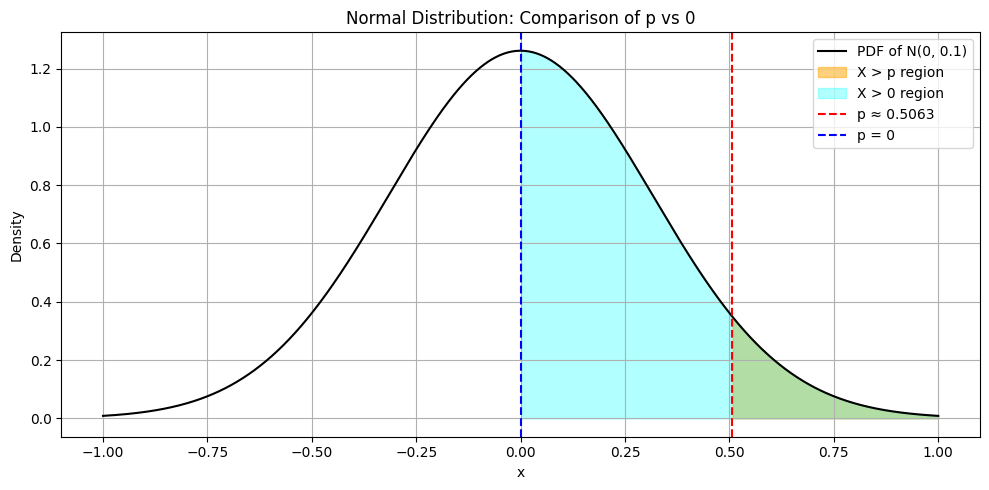

✅ 최적 기준값 p와 기준선 0 비교 결과:
p 기준:              p ≈ 0.5063
                     P(X > p)          = 0.05468
                     E[X² | X > p]     = 0.42424
                     Product           = 0.02320

0 기준:              p = 0
                     P(X > 0)          = 0.50000
                     E[X² | X > 0]     = 0.10000
                     Product           = 0.05000

🔹 전체 E[X²]         = 0.10000


In [13]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

# 설정
sigma2 = 0.1
sigma = np.sqrt(sigma2)
target = 0.00338/0.34/3/(1/7) #0.025

# 최적화 대상 함수
def objective(p):
    z = p / sigma
    prob = norm.sf(z)
    pdf = norm.pdf(z)
    sf = norm.sf(z)
    EX2_given = sigma2 * (1 + (z * pdf) / sf)
    return abs(prob * EX2_given - target)

# 최적 p 찾기
result = minimize_scalar(objective, bounds=(0, 1), method='bounded')
p_opt = result.x
z_opt = p_opt / sigma
prob_opt = norm.sf(z_opt)
pdf_opt = norm.pdf(z_opt)
EX2_given_opt = sigma2 * (1 + (z_opt * pdf_opt) / prob_opt)
product_opt = prob_opt * EX2_given_opt

# 기준점 0에 대한 비교 값
z_0 = 0 / sigma
prob_0 = norm.sf(z_0)
pdf_0 = norm.pdf(z_0)
EX2_given_0 = sigma2 * (1 + (z_0 * pdf_0) / prob_0)
product_0 = prob_0 * EX2_given_0

# 분포 그리기
x_vals = np.linspace(-1, 1, 1000)
pdf_vals = norm.pdf(x_vals, loc=0, scale=sigma)

plt.figure(figsize=(10, 5))
plt.plot(x_vals, pdf_vals, label='PDF of N(0, 0.1)', color='black')

# 기준선 영역 음영 (p)
x_shade_p = x_vals[x_vals > p_opt]
plt.fill_between(x_shade_p, norm.pdf(x_shade_p, 0, sigma), color='orange', alpha=0.5, label='X > p region')

# 기준선 영역 음영 (0)
x_shade_0 = x_vals[x_vals > 0]
plt.fill_between(x_shade_0, norm.pdf(x_shade_0, 0, sigma), color='cyan', alpha=0.3, label='X > 0 region')

# 기준선들
plt.axvline(p_opt, color='red', linestyle='--', label=f'p ≈ {p_opt:.4f}')
plt.axvline(0, color='blue', linestyle='--', label='p = 0')

plt.title("Normal Distribution: Comparison of p vs 0")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 결과 출력
print("✅ 최적 기준값 p와 기준선 0 비교 결과:")
print(f"p 기준:              p ≈ {p_opt:.4f}")
print(f"                     P(X > p)          = {prob_opt:.5f}")
print(f"                     E[X² | X > p]     = {EX2_given_opt:.5f}")
print(f"                     Product           = {product_opt:.5f}")

print(f"\n0 기준:              p = 0")
print(f"                     P(X > 0)          = {prob_0:.5f}")
print(f"                     E[X² | X > 0]     = {EX2_given_0:.5f}")
print(f"                     Product           = {product_0:.5f}")

print(f"\n🔹 전체 E[X²]         = {sigma2:.5f}")


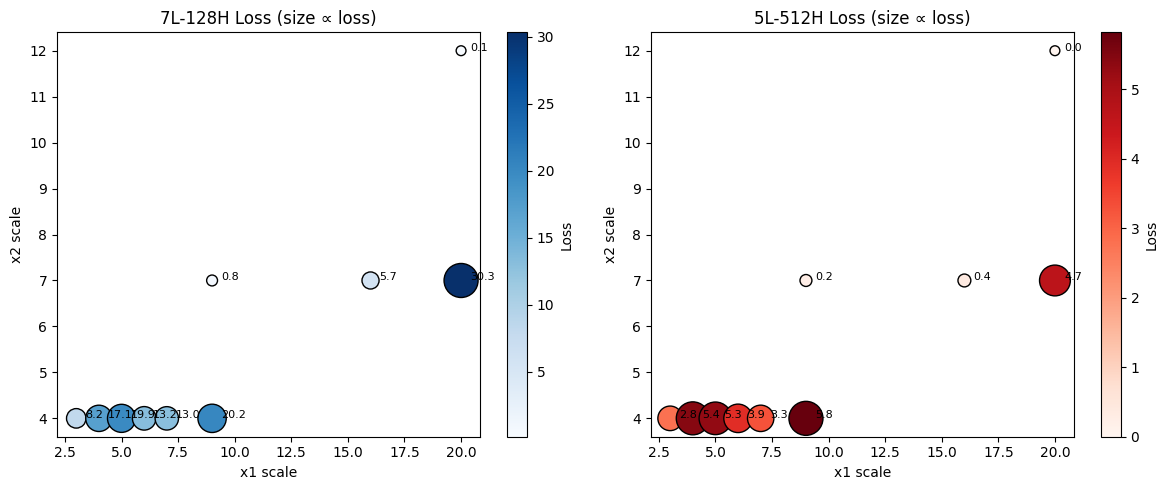

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 데이터
x1 = np.array([3, 4, 5, 6, 7, 9, 9, 16, 20, 20])
x2 = np.array([4, 4, 4, 4, 4, 4, 7, 7, 7, 12])
loss_7L_128H = np.array([8.22, 17.07, 19.85, 13.15, 12.98, 20.23, 0.76, 5.69, 30.34, 0.13])
loss_5L_512H = np.array([2.78, 5.44, 5.31, 3.92, 3.29, 5.82, 0.25, 0.38, 4.68, 0.00])

# 점 크기 스케일 함수 (loss가 클수록 원이 커지게)
def scale_size(loss, min_size=50, max_size=600):
    loss = np.clip(loss, 0, None)  # 음수 방지
    norm_loss = (loss - loss.min()) / (loss.max() - loss.min() + 1e-8)
    return min_size + norm_loss * (max_size - min_size)

sizes_7L = scale_size(loss_7L_128H)
sizes_5L = scale_size(loss_5L_512H)

# 시각화
plt.figure(figsize=(12, 5))

# ───── 7L-128H ─────
plt.subplot(1, 2, 1)
sc1 = plt.scatter(x1, x2, s=sizes_7L, c=loss_7L_128H, cmap='Blues', edgecolors='black')
for i in range(len(x1)):
    plt.text(x1[i]+0.4, x2[i], f"{loss_7L_128H[i]:.1f}", fontsize=8)
plt.title("7L-128H Loss (size ∝ loss)")
plt.xlabel("x1 scale")
plt.ylabel("x2 scale")
plt.colorbar(sc1, label="Loss")

# ───── 5L-512H ─────
plt.subplot(1, 2, 2)
sc2 = plt.scatter(x1, x2, s=sizes_5L, c=loss_5L_512H, cmap='Reds', edgecolors='black')
for i in range(len(x1)):
    plt.text(x1[i]+0.4, x2[i], f"{loss_5L_512H[i]:.1f}", fontsize=8)
plt.title("5L-512H Loss (size ∝ loss)")
plt.xlabel("x1 scale")
plt.ylabel("x2 scale")
plt.colorbar(sc2, label="Loss")

plt.tight_layout()
plt.show()


RuntimeError: output with shape [1] doesn't match the broadcast shape [1, 599, 1]

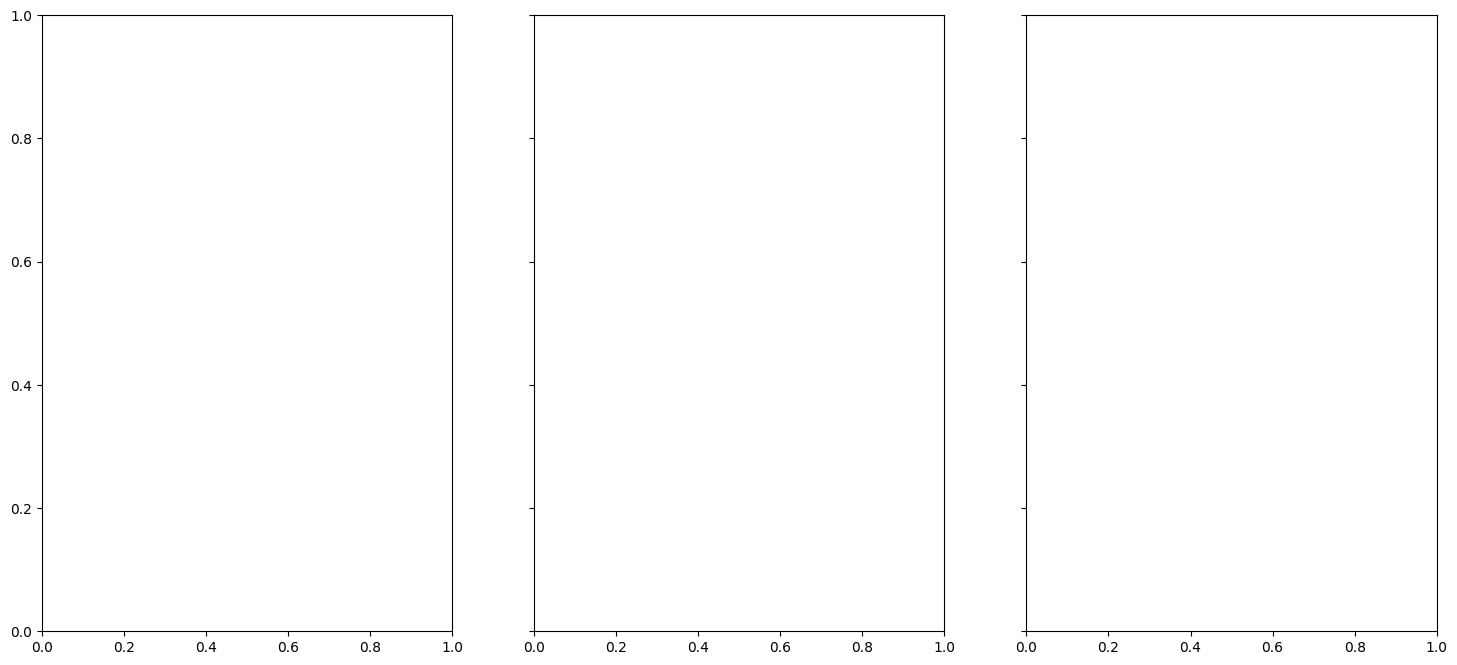

In [15]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# 스케일 값 정의
scaling_values = [3.0, 4.0, 5.0]
num_plots = len(scaling_values)

# 최대 y값 계산용
x_constraint = np.linspace(0, total_steps, total_steps)
max_y_val = 6

# subplot 생성
fig, axs = plt.subplots(1, num_plots, figsize=(6 * num_plots, 8), sharey=True)

if num_plots == 1:
    axs = [axs]

for idx, scaling in enumerate(scaling_values):
    Ref_traj = torch.ones(total_steps) * (-scaling)
    Ref_traj[:400] = scaling

    C_Ref_traj_up = torch.tensor(3 + 0.5 * np.sin(2 * np.pi * x_constraint / 200))
    C_Ref_traj_low = -C_Ref_traj_up

    # 정규화
    Ref_traj_norm = Ref_traj / (x1_diff / 2)
    C_low_norm = C_Ref_traj_low / (x2_diff / 2)
    C_up_norm = C_Ref_traj_up / (x2_diff / 2)

    # 슬라이딩 윈도우
    sliding_data_ref_x1 = Ref_traj_norm.unfold(0, window, 1)
    sliding_data_con_x2 = torch.stack(
        (C_low_norm.unfold(0, window, 1), C_up_norm.unfold(0, window, 1)), dim=-1
    )

    num_steps = len(Ref_traj) - window + 1
    x_trajectory = torch.zeros(num_steps, 2)
    u_trajectory = torch.zeros(num_steps, 1)

    for i in range(num_steps - 20):
        x_past = x_trajectory[i:i+window].unsqueeze(0)
        u_past = u_trajectory[i:i+window].unsqueeze(0)
        x_ref = sliding_data_ref_x1[i+window].unsqueeze(0)
        c_fut = sliding_data_con_x2[i+window].unsqueeze(0)

        u_future_policy, u_decision = NNPolicy_iteration(x_ref, x_past, u_past, c_fut, NNPolicy_basic)

        u_trajectory[i+window] = u_decision
        x_f = x_trajectory[i+window].unsqueeze(-1)
        u_f = u_decision.unsqueeze(0).unsqueeze(0)

        x_f_denorm = x_f.clone()
        u_f_denorm = u_f.clone()
        x_f_denorm[0] *= (x1_diff / 2)
        x_f_denorm[1] *= (x2_diff / 2)
        u_f_denorm[0] *= (u_diff / 2)

        x_np = x_f_denorm.detach().numpy()
        u_np = u_f_denorm.detach().numpy()
        x_next = torch.tensor(f_ss(x_np, u_np), dtype=torch.float32).squeeze(-1)

        x_next[0] /= (x1_diff / 2)
        x_next[1] /= (x2_diff / 2)
        x_trajectory[i+window+1] = x_next

    # 역정규화
    x_trajectory[:, 0] *= (x1_diff / 2)
    x_trajectory[:, 1] *= (x2_diff / 2)

    ax = axs[idx]
    ax.plot(x_trajectory[:, 0].numpy(), label="x1", color="b")
    ax.plot(x_trajectory[:, 1].numpy(), label="x2", color="g")
    ax.plot(Ref_traj.numpy(), label="Ref", linestyle="dotted", color="r")
    ax.plot(C_Ref_traj_low.numpy(), label="Lower", linestyle="--", color="gray")
    ax.plot(C_Ref_traj_up.numpy(), label="Upper", linestyle="--", color="gray")
    ax.set_title(f"Scaling = {scaling}")
    ax.set_xlabel("Step")
    ax.set_ylim(-max_y_val * 1.2, max_y_val * 1.2)
    ax.grid(True)

axs[0].set_ylabel("Values")
axs[-1].legend(loc="upper right")
plt.tight_layout()
plt.show()


In [ ]:
import torch.nn.functional as F
import pandas as pd

# loss 계산 범위 지정 (100~700)
start_step = 100
end_step = 700


results = []

with torch.no_grad():
    for scaling in scaling_values:
        Ref_traj = torch.ones(total_steps) * (-scaling)
        Ref_traj[:400] = scaling

        x_constraint = np.linspace(0, total_steps, total_steps)
        C_Ref_traj_up = torch.tensor(scaling + 0.5 * np.sin(2 * np.pi * x_constraint / 200))
        C_Ref_traj_low = -C_Ref_traj_up

        # Normalization
        Ref_traj = Ref_traj / (x1_diff / 2)
        C_Ref_traj_low = C_Ref_traj_low / (x2_diff / 2)
        C_Ref_traj_up = C_Ref_traj_up / (x2_diff / 2)

        sliding_data_ref_x1 = Ref_traj.unfold(0, window, 1)
        sliding_data_con_x2_low = C_Ref_traj_low.unfold(0, window, 1)
        sliding_data_con_x2_up = C_Ref_traj_up.unfold(0, window, 1)
        sliding_data_con_x2 = torch.stack((sliding_data_con_x2_low, sliding_data_con_x2_up), dim=-1)

        num_steps = len(Ref_traj) - window + 1
        x_trajectory = torch.zeros(num_steps, 2, dtype=torch.float32)
        u_trajectory = torch.zeros(num_steps, 1, dtype=torch.float32)

        for i in range(num_steps - 20):
            x_past_policy = x_trajectory[i:i+window, :].unsqueeze(0)
            u_past_policy = u_trajectory[i:i+window, :].unsqueeze(0)
            x_ref_policy = sliding_data_ref_x1[i+window].unsqueeze(0)
            c_fut_policy = sliding_data_con_x2[i+window].unsqueeze(0)

            u_future_policy, u_future_decision_policy = NNPolicy_iteration(
                x_ref_policy, x_past_policy, u_past_policy, c_fut_policy, NNPolicy_basic
            )

            u_trajectory[i+window] = u_future_decision_policy.squeeze()
            x_f = x_trajectory[i+window, :].unsqueeze(-1)
            u_f = u_future_decision_policy.unsqueeze(0).unsqueeze(0)

            x_f_denorm = x_f.clone()
            u_f_denorm = u_f.clone()
            x_f_denorm[0] *= (x1_diff / 2)
            x_f_denorm[1] *= (x2_diff / 2)
            u_f_denorm[0] *= (u_diff / 2)

            x_f_np = x_f_denorm.detach().cpu().numpy()
            u_f_np = u_f_denorm.detach().cpu().numpy()
            x_next = torch.tensor(f_ss(x_f_np, u_f_np), dtype=torch.float32).squeeze(-1)

            x_next[0] = x_next[0] / (x1_diff / 2)
            x_next[1] = x_next[1] / (x2_diff / 2)
            x_trajectory[i+window+1, :] = x_next

        # Denormalize
        x_trajectory[:, 0] *= (x1_diff / 2)
        x_trajectory[:, 1] *= (x2_diff / 2)
        u_trajectory[:, 0] *= (u_diff / 2)
        Ref_traj = Ref_traj * (x1_diff / 2)
        C_Ref_traj_low = C_Ref_traj_low * (x2_diff / 2)
        C_Ref_traj_up = C_Ref_traj_up * (x2_diff / 2)

        # Losses
        x1_pred = x_trajectory[start_step:end_step, 0].unsqueeze(0).unsqueeze(-1)
        x2_pred = x_trajectory[start_step:end_step, 1].unsqueeze(0).unsqueeze(-1)
        model_output = torch.stack([x1_pred, x2_pred], dim=2)  # [1, T, 2, 1]

        target_x1 = Ref_traj[start_step:end_step].unsqueeze(0).unsqueeze(-1)
        dummy_x2 = torch.zeros_like(target_x1)
        target = torch.cat([target_x1, dummy_x2], dim=2)

        u_output = u_trajectory[start_step:end_step].unsqueeze(0)
        c_fut = torch.stack([
            C_Ref_traj_low[start_step:end_step],
            C_Ref_traj_up[start_step:end_step]
        ], dim=-1).unsqueeze(0)

        model_output = model_output.squeeze(-1)
        model_output_x1 = model_output[:, :, 0]
        model_output_x2 = model_output[:, :, 1]

        errors = (target[:, :, 0] - model_output_x1) ** 2
        u_diff_val = u_output[:, 1:, :] - u_output[:, :-1, :]
        squared_diff = u_diff_val ** 2

        low_violation = F.relu(c_fut[:, :, 0] - model_output_x2) ** 2
        up_violation = F.relu(model_output_x2 - c_fut[:, :, 1]) ** 2
        constraint_violation = low_violation + up_violation

        tracking_loss = torch.sqrt(errors.mean()).item()
        smoothness_loss = 0.1 * torch.sqrt(squared_diff.mean()).item()
        constraint_loss = 3 * torch.sqrt(constraint_violation.mean()).item()
        total_loss = tracking_loss + smoothness_loss + constraint_loss

        # Constraint RMSE
        x2 = x_trajectory[:, 1]
        diff_to_lower = torch.abs(x2[start_step:end_step] - C_Ref_traj_low[start_step:end_step])
        diff_to_upper = torch.abs(x2[start_step:end_step] - C_Ref_traj_up[start_step:end_step])
        min_diff = torch.minimum(diff_to_lower, diff_to_upper)
        constraint_distance_rmse = torch.sqrt((min_diff ** 2).mean()).item()

        results.append({
            "Scaling": scaling,
            "Tracking Loss": tracking_loss,
            "Smoothness Loss": smoothness_loss,
            "Constraint Loss": constraint_loss,
            "Total Loss": total_loss,
            "Constraint RMSE": constraint_distance_rmse
        })

import pandas as pd

# results → DataFrame
df_results = pd.DataFrame(results)

# 열 순서 정렬 (보기 좋게)
df_results = df_results[[
    "Scaling",
    "Tracking Loss",
    "Smoothness Loss",
    "Constraint Loss",
    "Total Loss",
    "Constraint RMSE"
]]

# 콘솔 출력 (한 행에 나란히)
print("\n📊 Loss & Constraint RMSE Summary Table")
print(df_results.to_string(index=False))  # 인덱스 제거해서 깔끔하게

# CSV로 저장도 가능
df_results.to_csv("loss_constraint_results.csv", index=False)
print("\n✅ CSV 저장 완료: loss_constraint_results.csv")





📊 Loss & Constraint RMSE Summary Table
 Scaling  Tracking Loss  Smoothness Loss  Constraint Loss  Total Loss  Constraint RMSE
     3.0       1.125532         0.011097              0.0    1.136630         0.176973
     4.0       1.466600         0.014761              0.0    1.481360         0.210000
     5.0       1.813163         0.018396              0.0    1.831559         0.249613

✅ CSV 저장 완료: loss_constraint_results.csv


In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# 스케일 값 정의
scaling_values = [3.5, 4.5, 5.5]
num_plots = len(scaling_values)

# 최대 y값 계산용
x_constraint = np.linspace(0, total_steps, total_steps)
max_y_val = max([np.max(np.abs(s + 0.5 * np.sin(2 * np.pi * x_constraint / 200))) for s in scaling_values])

# subplot 생성
fig, axs = plt.subplots(1, num_plots, figsize=(6 * num_plots, 8), sharey=True)

if num_plots == 1:
    axs = [axs]

for idx, scaling in enumerate(scaling_values):
    Ref_traj = torch.ones(total_steps) * (-scaling)
    Ref_traj[:400] = scaling

    C_Ref_traj_up = torch.tensor(scaling + 0.5 * np.sin(2 * np.pi * x_constraint / 200))
    C_Ref_traj_low = -C_Ref_traj_up

    # 정규화
    Ref_traj_norm = Ref_traj / (x1_diff / 2)
    C_low_norm = C_Ref_traj_low / (x2_diff / 2)
    C_up_norm = C_Ref_traj_up / (x2_diff / 2)

    # 슬라이딩 윈도우
    sliding_data_ref_x1 = Ref_traj_norm.unfold(0, window, 1)
    sliding_data_con_x2 = torch.stack(
        (C_low_norm.unfold(0, window, 1), C_up_norm.unfold(0, window, 1)), dim=-1
    )

    num_steps = len(Ref_traj) - window + 1
    x_trajectory = torch.zeros(num_steps, 2)
    u_trajectory = torch.zeros(num_steps, 1)

    for i in range(num_steps - 20):
        x_past = x_trajectory[i:i+window].unsqueeze(0)
        u_past = u_trajectory[i:i+window].unsqueeze(0)
        x_ref = sliding_data_ref_x1[i+window].unsqueeze(0)
        c_fut = sliding_data_con_x2[i+window].unsqueeze(0)

        u_future_policy, u_decision = NNPolicy_iteration(x_ref, x_past, u_past, c_fut, NNPolicy_basic)

        u_trajectory[i+window] = u_decision
        x_f = x_trajectory[i+window].unsqueeze(-1)
        u_f = u_decision.unsqueeze(0).unsqueeze(0)

        x_f_denorm = x_f.clone()
        u_f_denorm = u_f.clone()
        x_f_denorm[0] *= (x1_diff / 2)
        x_f_denorm[1] *= (x2_diff / 2)
        u_f_denorm[0] *= (u_diff / 2)

        x_np = x_f_denorm.detach().numpy()
        u_np = u_f_denorm.detach().numpy()
        x_next = torch.tensor(f_ss(x_np, u_np), dtype=torch.float32).squeeze(-1)

        x_next[0] /= (x1_diff / 2)
        x_next[1] /= (x2_diff / 2)
        x_trajectory[i+window+1] = x_next

    # 역정규화
    x_trajectory[:, 0] *= (x1_diff / 2)
    x_trajectory[:, 1] *= (x2_diff / 2)

    ax = axs[idx]
    ax.plot(x_trajectory[:, 0].numpy(), label="x1", color="b")
    ax.plot(x_trajectory[:, 1].numpy(), label="x2", color="g")
    ax.plot(Ref_traj.numpy(), label="Ref", linestyle="dotted", color="r")
    ax.plot(C_Ref_traj_low.numpy(), label="Lower", linestyle="--", color="gray")
    ax.plot(C_Ref_traj_up.numpy(), label="Upper", linestyle="--", color="gray")
    ax.set_title(f"Scaling = {scaling}")
    ax.set_xlabel("Step")
    ax.set_ylim(-max_y_val * 1.2, max_y_val * 1.2)
    ax.grid(True)

axs[0].set_ylabel("Values")
axs[-1].legend(loc="upper right")
plt.tight_layout()
plt.show()
